# Add command-line parameter to existing tool

Author: Zhengguo Tan <zhengguo.tan@med.uni-goettingen.de>

This notebook covers

    1. available functions to build command-line parameters;

    2. demo - adding partial-Fourier sampling trajectory to the traj tool


Note that the kernel used here is `Bash`, but not `Python`. Detailed installation will be covered by Jon in the next part.

## Set up BART

- This notebook works with the `BART` master branch from github: 

In [1]:
export BART_FOLDER="bart_webinar"
export PYTHONPATH="${BART_DIR}/python"

pip install numpy matplotlib

if [ ! -d "${BART_FOLDER}" ]
then
    git clone https://github.com/mrirecon/bart ${BART_FOLDER}
fi

cd ${BART_FOLDER}

git checkout 959ef28

export MAKEFLAGS+=--silent
PARALLEL=1 make

Note: checking out '959ef28'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 959ef28 support non-Cartesian trajectories in nlinv tool


- Since people may have multiple `BART` installed, it's necessary to specify the BART directory used in this notebook.

In [2]:
source startup.sh
export BART_DIR=${TOOLBOX_PATH}
cd ..

## Command-line parameters

### Use `traj` as an example

In [3]:
${BART_DIR}/bart traj -h

Usage: traj [-x d] [-y d] [-a d] [-t d] [-m d] [-l] [-g] [-r] [-G] [-H] [-s d] [-D] [-R f] [-q ...] [-Q ...] [-O] [-3] [-c] [-z ...] [-C <string>] <output>

Computes k-space trajectories.

-x x      	readout samples
-y y      	phase encoding lines
-a a      	acceleration
-t t      	turns
-m mb      	SMS multiband factor
-l		aligned partition angle
-g		golden angle in partition direction
-r		radial
-G		golden-ratio sampling
-H		halfCircle golden-ratio sampling
-s # Tiny GA      	tiny golden angle
-D		projection angle in [0,360°), else in [0,180°)
-R phi      	rotate
-q delays      	gradient delays: x, y, xy
-Q delays      	(gradient delays: z, xz, yz)
-O		correct transverse gradient error for radial tajectories
-3		3D
-c		asymmetric trajectory [DC sampled]
-z Ref:Acel      	Undersampling in z-direction.
-C file      	custom_angle file [phi + i * psi]
-h		help


- BART uses single characters for command-line options;

- BART supports various input types, e.g. int, float, bool, vector, string;

- BART allows optional outputs.


- The usage string lists the tool name, all command characters and associated input types, as well as outputs.

### Implementation details

- Every tool in BART has a corresponding c file under the `src/` folder;

- This c file is named by the tool name;

- `struct opts_s` construction in `src/traj.c`:

```c
int X = 128;
float rot = 0.;
struct traj_conf conf = traj_defaults;
const char* custom_angle = NULL;

const struct opt_s opts[] = {

    OPT_INT('x', &X, "x", "readout samples"),

    OPT_FLOAT('R', &rot, "phi", "rotate"),

    OPT_SET('r', &conf.radial, "radial"),

    OPT_FLVEC3('q', &gdelays[0], "delays", "gradient delays: x, y, xy"),

    OPT_STRING('C', &custom_angle, "file", "custom_angle file [phi + i * psi]"),
};

cmdline(&argc, argv, 1, 1, usage_str, help_str, ARRAY_SIZE(opts), opts);
```

- the macro `OPT_***` function:

    1. command character;
    
    2. address of the variable;
    
    3. short name;
    
    4. full description.


- The `cmdline` function is used to process all options defined in the `opts` struct.

### Special case: regularizations in `src/pics.c`

```c
const struct opt_s opts[] = {

    { 'l', true, opt_reg, &ropts, "1/-l2\t\ttoggle l1-wavelet or l2 regularization." },

    { 'R', true, opt_reg, &ropts, " <T>:A:B:C\tgeneralized regularization options (-Rh for help)" },

};
```

- Here, the `opt_reg` function is used to process the input variables and save them to the `struct ropts`;

- If you develop new regularizations in BART, you may need to modify this function

### Example 1. create a Cartesian sampling trajectory

In [4]:
TRAJ_FILE=demo_traj # output cfl file

FREQ_ENC=256
PHAS_ENC=256

${BART_DIR}/bart traj -x ${FREQ_ENC} -y ${PHAS_ENC} ${TRAJ_FILE}

${BART_DIR}/bart show -m ${TRAJ_FILE}

rm ${TRAJ_FILE}.{cfl,hdr}

Type: complex float
Dimensions: 16
AoD:	3	256	256	1	1	1	1	1	1	1	1	1	1	1	1	1


### Example 2. create a radial small-Golden-angle sampling trajectory

traj dims:  (3, 32, 7, 1, 1, 1, 1, 1, 1, 1, 5)


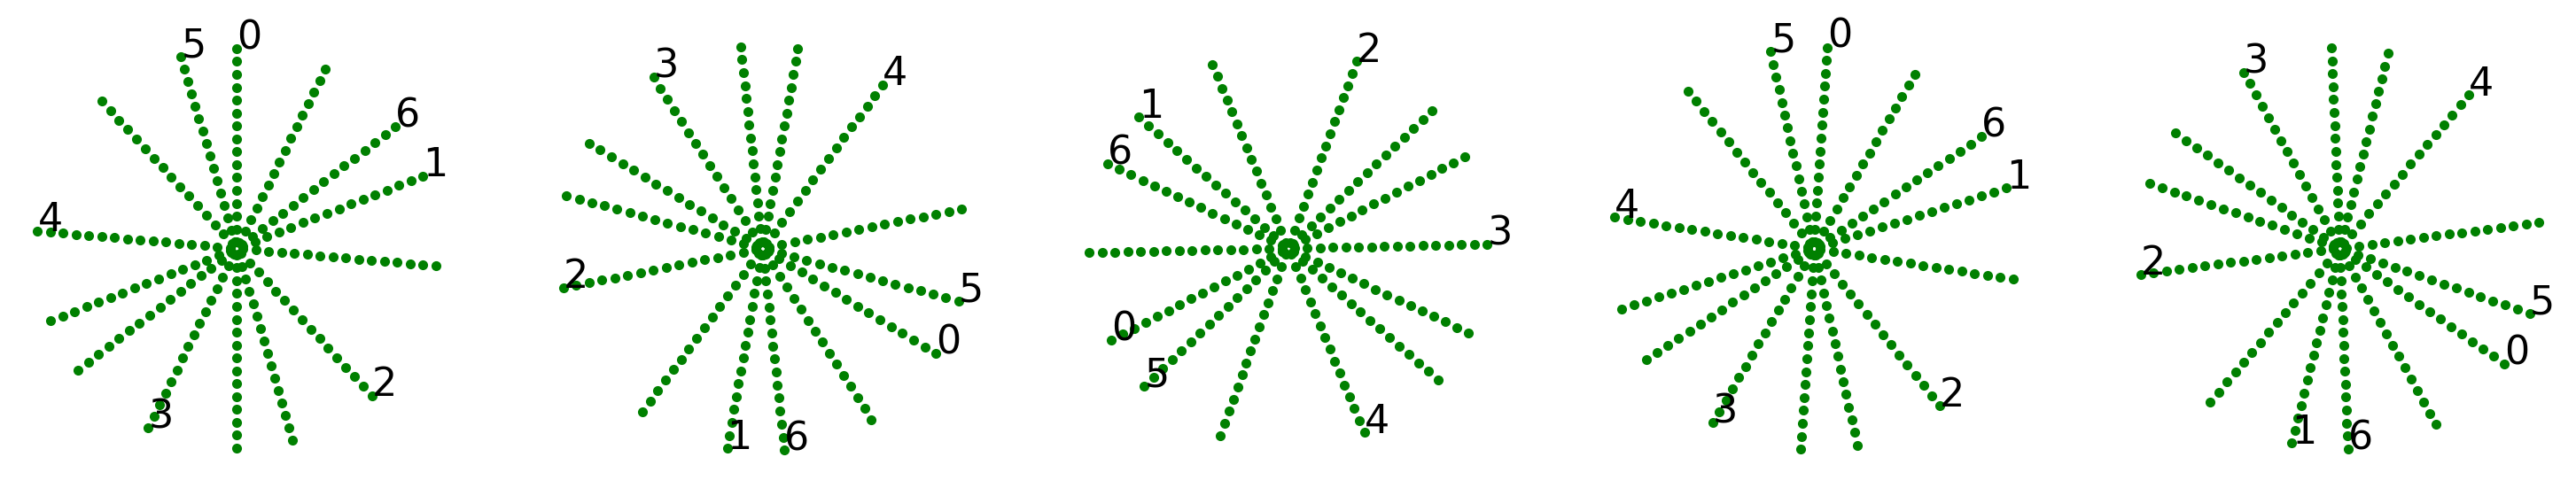

In [5]:
TRAJ_FILE=demo_traj

${BART_DIR}/bart traj -x 32 -y 7 -t 5 -r -G -s 2 -D ${TRAJ_FILE}

TRAJ_FIG=${TRAJ_FILE}_fig
python plot_traj.py ${TRAJ_FILE} ${TRAJ_FIG}

display < ${TRAJ_FIG}.png

rm ${TRAJ_FILE}.{cfl,hdr} ${TRAJ_FIG}.png

**[explanation]**

- 32 readout samples per echo;

- 7 spokes per frame;

- spoke angle is always incremented by the small Golden angle (i.e. $68.75388..^o$)

### Visualization

In [6]:
sed -n '16,27p' < plot_traj.py

def plot_traj(traj_file, png_file):
    
    traj = cfl.readcfl(traj_file)
    print('traj dims: ', traj.shape)

    D = traj.ndim
    if D < 16:
        
        for d in range(D, 16, 1):
            traj = np.expand_dims(traj, axis=d)
    
    assert traj.ndim == 16


In [7]:
sed -n '36,52p' < plot_traj.py

    for nf in range(N_frm):

        ax = plt.subplot(1,N_frm, nf+1)

        for ne in range(N_eco):

            for ns in range(N_spk):

                kx = np.squeeze(traj[0,:,ns,0,0,ne,0,0,0,0,nf])
                ky = np.squeeze(traj[1,:,ns,0,0,ne,0,0,0,0,nf])
                plt.plot(kx.real, ky.real, '.g')
                plt.axis('off')
                ax.set_aspect('equal', 'box')
                plt.text(kx[-1].real, ky[-1].real, str(ns), fontsize=16)
    
    plt.savefig(png_file, bbox_inches='tight', dpi=200)
    plt.close()


**[note]** multiple `for` loops are used.

## Demonstration

### Partial-Fourier sampling

0) go to `src/traj.c`

1) Since "X" is the actual readout samples, define "D" as the full readout samples:
```c
    int D = -1;
```
2) pass it to the *struct opt_s*:
```c
		OPT_INT('d', &D, "d", "full readout samples"),
```
3) fuse it:
```c
	if (-1 == D)
		D = X;

	if (D < X)
	    error("actual readout samples must be less than full samples");
```
4) modify the *read* calculation in looping:
```c
            // old: read goes from -X/2 to X/2-1
            double read = (float)i + (conf.asym_traj ? 0 : 0.5) - (float)X / 2.;

            // new: read goes from D/2-X to D/2-1
			double read = (float)(i + D - X) + (conf.asym_traj ? 0 : 0.5) - (float)D / 2.; 
```
5) with the above modifications, you should make/compile your BART

In [8]:
cd ${BART_DIR}

git checkout 8b759e4
make

cd ..

Previous HEAD position was 959ef28 support non-Cartesian trajectories in nlinv tool
HEAD is now at 8b759e4 add partial-Fourier trajectory


### Excercise 1. create a partial-Fourier radial trajectory with the turn-based view order and $360^o$ view angle

traj dims:  (3, 24, 7, 1, 1, 1, 1, 1, 1, 1, 5)


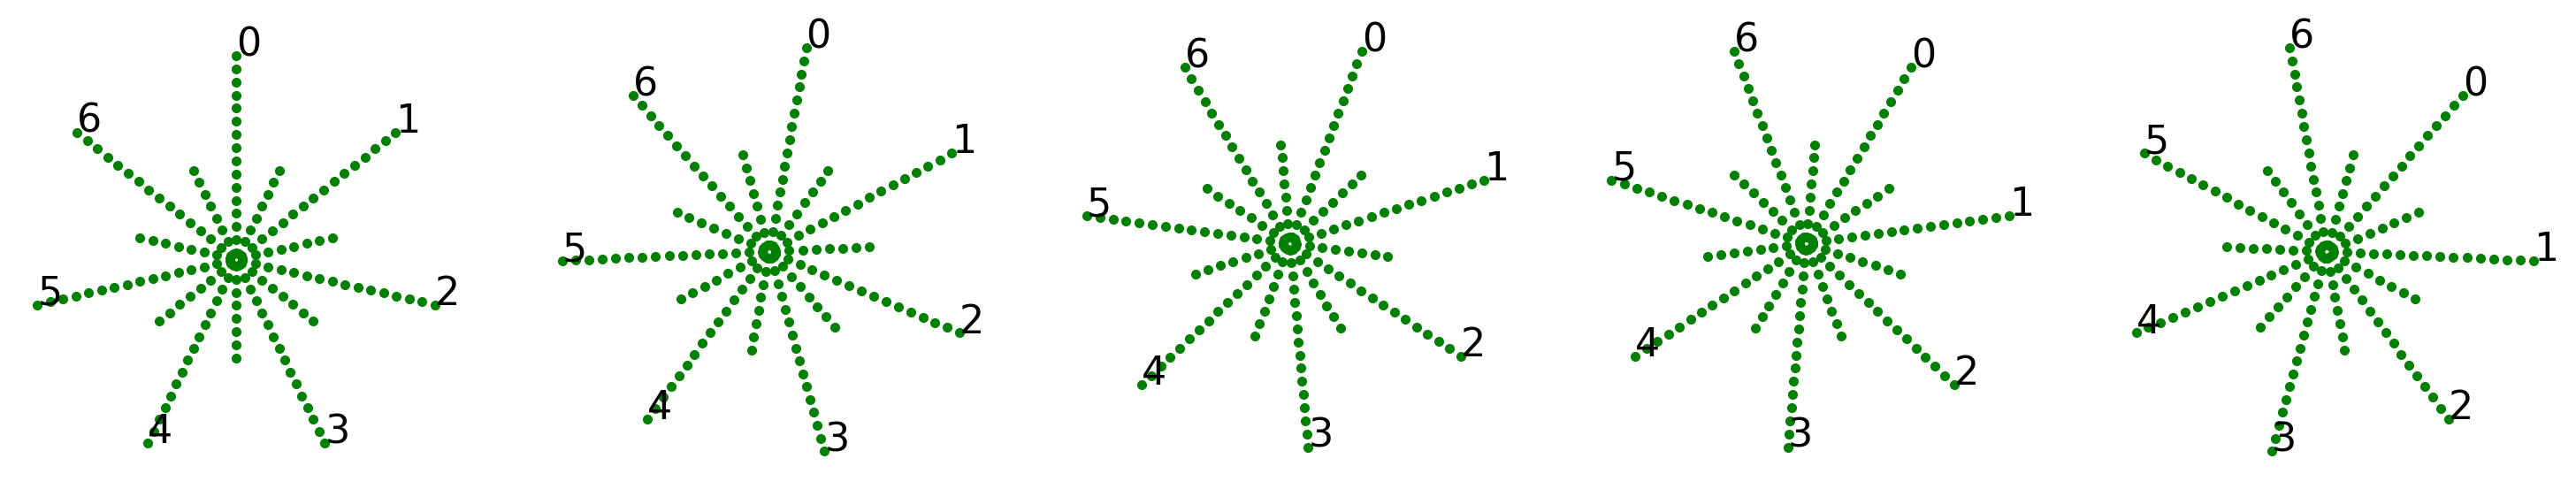

In [9]:
TRAJ_FILE=demo_traj

${BART_DIR}/bart traj -x 24 -d 32 -y 7 -t 5 -r -D ${TRAJ_FILE}

TRAJ_FIG=${TRAJ_FILE}_fig

python plot_traj.py ${TRAJ_FILE} ${TRAJ_FIG}

display < ${TRAJ_FIG}.png

rm ${TRAJ_FILE}.{cfl,hdr} ${TRAJ_FIG}.png

### Excercise 2. create a partial-Fourier radial trajectory with the turn-based view order and  $180^0$  view angle

traj dims:  (3, 24, 7, 1, 1, 1, 1, 1, 1, 1, 5)


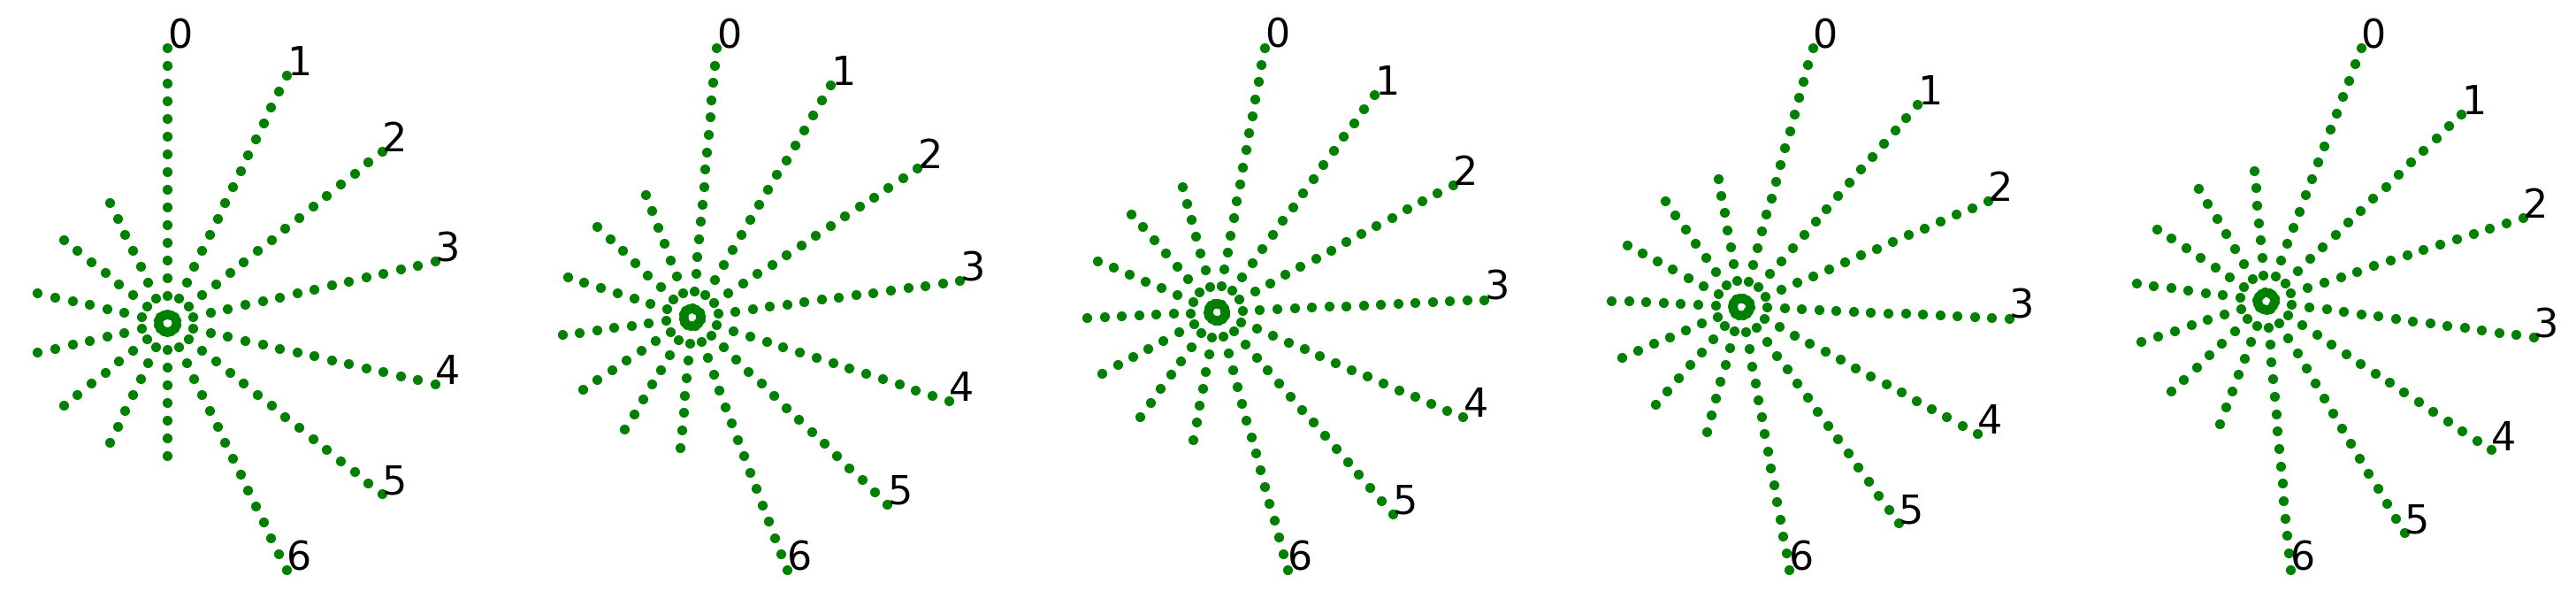

In [10]:
TRAJ_FILE=demo_traj

${BART_DIR}/bart traj -x 24 -d 32 -y 7 -t 5 -r ${TRAJ_FILE}

TRAJ_FIG=${TRAJ_FILE}_fig

python plot_traj.py ${TRAJ_FILE} ${TRAJ_FIG}

display < ${TRAJ_FIG}.png

rm ${TRAJ_FILE}.{cfl,hdr} ${TRAJ_FIG}.png

### Optional: Looping structure in `src/traj.c`

Instead of using multiple `for` loops to go over every dimension of the sampling scheme (e.g. spokes/phase encoding, echoes, frames, slices, etc), `src/traj.c` uses a generic funciton - `md_next`

```c
    long pos[DIMS] = { 0 };

    do {

        int i = pos[PHS1_DIM];
        
        ... 
        
        // calculate every readout samples
        double read = (float)(i + D - X) - (float)D / 2.;
        
        ...

    } while( md_next(DIMS, dims, ~1L, pos) );
```

In [11]:
cd ${BART_DIR}

git checkout master

cd ..

Switched to branch 'master'
Your branch is up to date with 'origin/master'.


## Short summary

- BART accepts single-character command;

- BART supports various input types, and is flexible to be extended;


- We have shown how to add a new command-line parameter to `src/traj.c` for partial-Fourier trajectory calculation.


Thank you for joining our webinar! We hope you had some fun with it and learned a lot! :)